In [371]:
#import stuff
import pandas as pd
import numpy as np
import seaborn as s
from matplotlib import pyplot as plt
import numpy.linalg as la
import lib as l
import copy
import tqdm
from sklearn.metrics import confusion_matrix as cm
from scipy.spatial import ConvexHull as ch
from matplotlib import animation as ani
from matplotlib.animation import FuncAnimation as fn

In [147]:
#import data
pokemon = pd.read_csv('data/pokemon.csv', header = None, 
                     skiprows=1, encoding = 'latin-1', low_memory = False,
                    names = ['Name', 'Version', 'Primary Type' ,'Secondary Type', 'Stage' ,'Attack', 'Defense' , 'HP', 'Sp. Attack', 'Sp. Defense', 'Speed', 'Total', 'Legendary']
)

img = plt.imread("logo.png") # get the pokemon logo :)

#divide sets function
def divideSets(p,data):
    copydata = copy.deepcopy(data)
    np.random.shuffle(copydata)
    list1 = copydata[:int(p*len(copydata))]
    list2 = copydata[int(p*len(copydata)):]
    return (list1,list2)

#for contour plot stuff
def f(x,y):
    return 2*x + 1*y

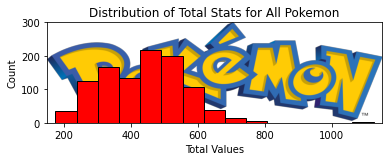

In [148]:
#distribution of total values
pokemon['Total'].hist(color = 'red', ec = 'black', grid = False, bins = 15)
plt.title("Distribution of Total Stats for All Pokemon")
plt.xlabel("Total Values")
plt.ylabel("Count")
plt.imshow(img, extent = [150, 1150, 0, 300])

In [295]:
pokemon.describe()

,Stage,Attack,Defense,HP,Sp. Attack,Sp. Defense,Speed,Total
count,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000
mean,1.616268,80.466986,74.661244,70.067943,73.022010,72.288995,68.807656,439.314833
std,0.709219,32.413665,31.237903,26.671411,32.724797,28.074148,30.210094,121.970701
min,1.000000,5.000000,5.000000,1.000000,10.000000,20.000000,5.000000,175.000000
25%,1.000000,55.000000,50.000000,50.000000,50.000000,50.000000,45.000000,330.000000
50%,1.000000,77.000000,70.000000,68.000000,65.000000,70.000000,65.000000,458.000000
75%,2.000000,100.000000,90.000000,82.000000,95.000000,90.000000,90.000000,515.000000
max,3.000000,190.000000,250.000000,255.000000,194.000000,250.000000,200.000000,1125.000000


# Question 1;

This is the data set of all current pokemon as of 11/23/21. This represents a statistical outlook of the 1045 pokemon. This includes legendaries, mythical, and mega evolution variants. Their attributes are broken down into 7 numerical categories. They represents how strong the corresponding attribute of the pokemon is. So the higher the value, the stronger the attribute will be. The categories are as follows:

    - HP
    - Attack
    - Defense
    - Special Attack
    - Special Defense
    - Speed
    - Total
    
These are not the actual values of the attributes. _i.e._ If I have a Lvl 100 Venusaur, I won't have 82 Attack. It is more like a scale that determines the boundaries that a pokemon's attributes are tied to. 

# Question 2;

There are few, not so obvious **classes** that are present in this data set. One of which can be determining if a pokemon is considered _Statistically Strong_. This has a vague definition, but generally the higher the pokemon's attributes are, the better they can do in battle. For our purpose, we will define statistically strong as _having a higher total than 500, as well as having at least 3 of their 6 attributes being in the third quartile of all values._ This will hopefully eliminate any outliers or pokemon that have all their power in a few stats. **(Blissey)**

Another class is whether the pokemon have a secondary type or not. There really is no correlation with the data we currently have, but if we added a column that gave us the evolution stage that a pokemon is in, (1, 2, or 3), we could define secondary types with evolution stage as a potential class. 

## Important Statistics & Info of the Set:

1. We will be excluding ALL mega evolution forms of pokemon as well as **Eternamax** for our KNN alg because they will cause some annoying skewing.

2. For our K-means clustering algorithm, we will be including all 1045 pokemon. This will prove our point later on that K-means is NOT a good algorithm to use on this data set.

We will provide some basic stats about our set below:

In [149]:
noMega = pokemon[pokemon['Version'].isnull()] # for KNN alg
stats = noMega.describe().round(3)
stats

,Stage,Attack,Defense,HP,Sp. Attack,Sp. Defense,Speed,Total
count,870.000,870.000,870.000,870.000,870.000,870.000,870.000,870.000
mean,1.614,76.017,71.511,68.706,69.117,69.387,65.143,419.882
std,0.704,29.471,29.533,26.272,29.061,26.859,28.110,110.641
min,1.000,5.000,5.000,1.000,10.000,20.000,5.000,180.000
25%,1.000,55.000,50.000,50.000,45.000,50.000,45.000,320.000
50%,1.000,75.000,67.000,65.000,65.000,65.000,64.000,430.000
75%,2.000,95.000,90.000,80.000,90.000,85.000,85.000,500.000
max,3.000,181.000,230.000,255.000,173.000,230.000,200.000,720.000


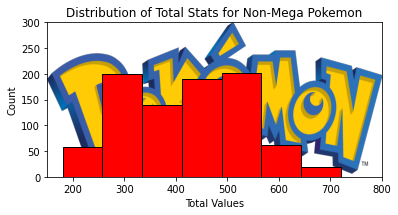

In [150]:
#distribution of total values (no mega or eternamax)
noMega['Total'].hist(color = 'red', ec = 'black', grid = False, bins = 7)
plt.title("Distribution of Total Stats for Non-Mega Pokemon")
plt.xlabel("Total Values")
plt.ylabel("Count")
plt.imshow(img, extent = [150, 800, 0, 300])

# K-nearest Neighbors Algorithm

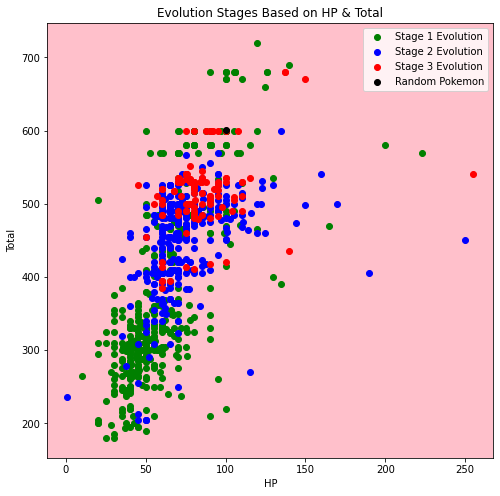

In [151]:
# SPLIT INTO OUR THREE STAGES 
stage_one = noMega[noMega['Stage'] == 1]
stage_two = noMega[noMega['Stage'] == 2]
stage_three = noMega[noMega['Stage'] == 3]

#make random pokemon
random_pokemon = [100, 601]

#PLOTTING
plt.scatter(x = stage_one['HP'], y = stage_one['Total'], color = 'g')
plt.scatter(x = stage_two['HP'], y = stage_two['Total'], color = 'b')
plt.scatter(x = stage_three['HP'], y = stage_three['Total'], color = 'r')
plt.scatter(x = random_pokemon[0], y = random_pokemon[1], color = 'black')
plt.title("Evolution Stages Based on HP & Total")
plt.legend(['Stage 1 Evolution', 'Stage 2 Evolution', 'Stage 3 Evolution', 'Random Pokemon'])
plt.xlabel("HP")
plt.ylabel("Total")
plt.gca().set_facecolor('pink')
plt.gcf().set_size_inches(8,8)

In [152]:
#Predicting what stage a pokemon is based off of HP and Total
knn = l.KNN(3)

knn_set = noMega[['HP', 'Total']].to_numpy()
labels = noMega['Stage'].values 

knn.train(knn_set, labels)

#predict random pokemon from above
pred = knn.predict(random_pokemon)
print(f'The predicted stage of {random_pokemon} is ~> Stage {pred.most_common(1)[0][0]}')

The predicted stage of [100, 601] is ~> Stage 1


## Issues with this Algorithm
The problem lies with the **legendary** pokemon.

Majority of them don't have an evolution path, so they are all considered stage 1. Therefore, it severely skews the data. Thus being difficult to predict pokemon with higher stats.

Below we can see the means for each stage.

In [364]:
new = noMega[['Total' , 'Stage']]

one = new[new['Stage'] == 1]
two = new[new['Stage'] == 2]
three = new[new['Stage'] == 3]

oneM = one['Total'].mean()
twoM = two['Total'].mean()
threeM = three['Total'].mean()

print(f'=========================\n\tNoMeg Total\n=========================\nStage 1 mean ~> {round(oneM,5)}')
print(f'Stage 2 mean ~> {round(twoM,5)}')
print(f'Stage 3 mean ~> {round(threeM,5)}\n=========================')
noMega[noMega['Stage'] == 3].describe()

	NoMeg Total
Stage 1 mean ~> 377.36161
Stage 2 mean ~> 446.95161
Stage 3 mean ~> 515.03571


,Stage,Attack,Defense,HP,Sp. Attack,Sp. Defense,Speed,Total
count,112.0,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,3.0,94.357143,83.812500,84.776786,88.803571,85.696429,77.589286,515.035714
std,0.0,26.738593,23.520178,24.213283,25.068138,19.955283,23.681655,52.539977
min,3.0,10.000000,10.000000,45.000000,35.000000,50.000000,25.000000,385.000000
25%,3.0,78.750000,70.000000,75.000000,70.000000,74.500000,60.000000,490.000000
50%,3.0,95.000000,80.000000,80.000000,90.000000,85.000000,78.000000,519.500000
75%,3.0,115.000000,95.000000,91.250000,109.000000,95.750000,95.000000,534.000000
max,3.0,160.000000,180.000000,255.000000,145.000000,154.000000,142.000000,680.000000


In [156]:
#print('True Evolution Stages \n', label2)
#print('\n Predicted Evolution Stages \n', predictions)
mcm = cm(label2,predictions)
nmcm= cm(label2,predictions, normalize = 'true')
print('Confusion Matrix: \n', mcm)
print('\n Normalized Confusion Matrix: \n', nmcm)

Confusion Matrix: 
 [[153  35  11]
 [ 18  70  15]
 [  9  15  22]]

 Normalized Confusion Matrix: 
 [[0.76884422 0.1758794  0.05527638]
 [0.17475728 0.67961165 0.14563107]
 [0.19565217 0.32608696 0.47826087]]


Note that **Stage 1** has a fairly high total mean, and the confusion matrix is not fantastic, considering they are the *weak* pokemon. The legendaries very much skew the set to have a larger mean than intended.

In [390]:
#get averages for presentation
sumR1 = 0
sumR2 = 0
sumR3 = 0
for i in tqdm.tqdm(range(0,100)): 
   
    knn_set = noMega[['HP', 'Total']].to_numpy()
    labels = noMega['Stage'].values 
    
    #stage 1 randoms
    hp1 = np.random.randint(10,224, (100,1))
    tot1 = np.random.randint(230,721, (100,1))
    
    #stage 2
    hp2 = hp1 = np.random.randint(1,250, (100,1))
    tot2 = np.random.randint(260,601, (100,1))
    
    #stage 3
    hp3 = np.random.randint(45,256, (100,1))
    tot3 = np.random.randint(385,681, (100,1))
    
    #vstack ftw
    hp = np.vstack((hp1,hp2,hp3))
    tot = np.vstack((tot1, tot2, tot3))
    data2 = np.hstack((hp, tot))
    
    lab1 = np.random.randint(1,2,(100,1))
    lab2 = np.random.randint(2,3,(100,1))
    lab3 = np.random.randint(3,4,(100,1))
    label2 = np.vstack((lab1,lab2,lab3))
    
    k = 3
    knn = l.KNN(k)

    knn.train(knn_set,labels)

    prediction = []
    for x in data2:
        prediction.append(knn.predict(x))
    
    predictions = [prediction[i].most_common(2)[0][0] for i in range(len(prediction))]

    mcm = cm(label2,predictions)
    nmcm= cm(label2,predictions, normalize = 'true')
    #print('Confusion Matrix: \n', mcm)
    #print('\n Normalized Confusion Matrix: \n', nmcm)
    sumR1 += nmcm[0][0]
    sumR2 += nmcm[1][1]
    sumR3 += nmcm[2][2]
    
aveR1 = sumR1 / 100
aveR2 = sumR2 / 100
aveR3 = sumR3 / 100

print(f'Stage 1 Averaged {round(aveR1*100,3)}% Correct\nStage 2 Averaged {round(aveR2 * 100,3)}% Correct\nStage 3 Averaged {round(aveR3 * 100,3)}% Correct')
print('Confusion Matrix: \n', mcm)
print('\n Normalized Confusion Matrix: \n', nmcm)

100%|██████████| 100/100 [02:46<00:00,  1.66s/it]

Stage 1 Averaged 59.77% Correct
Stage 2 Averaged 39.67% Correct
Stage 3 Averaged 15.01% Correct
Confusion Matrix: 
 [[63 22 15]
 [51 41  8]
 [48 42 10]]

 Normalized Confusion Matrix: 
 [[0.63 0.22 0.15]
 [0.51 0.41 0.08]
 [0.48 0.42 0.1 ]]


### Contour Plot Section (No mega)

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


We got 111 wrong!
So 12.759% of the data were wrongly predicted as Stage 1
Done


Text(0.5, 1.0, 'HP v Total no Alternates Stage 1')

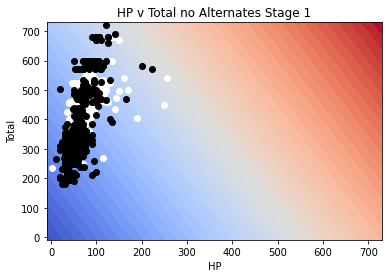

In [306]:
# Stage 1
X = noMega[['HP', 'Total']].values
Y = noMega['Stage']
Y = Y.replace([1,2,3], [1,0,0]).values.astype('float64') #if stage 1, Stage = 1, 0 otherwise
knn.train(X,Y)

#predict them!
prediction = []
for x in X:
    prediction.append(knn.predict(x))
predictions = [prediction[i].most_common(2)[0][0] for i in range(len(prediction))]

num_wrong = np.sum(np.not_equal(predictions, Y))
print(f'We got {num_wrong} wrong!\nSo {round(num_wrong/len(X) * 100, 3)}% of the data were wrongly predicted as Stage 1')

# plotting time
# make sure grid contains all of our data
r_min = np.min(X) - 10 
r_max = np.max(X) + 10

xs, ys = np.meshgrid(np.arange(r_min, r_max, 0.1), np.arange(r_min, r_max, 0.1))
zs = [ [ f(xs[i,j], ys[i,j]) for j in range(len(ys)) ] for i in range(len(xs)) ]
print("Done")
plt.contourf(xs, ys, zs, levels = 50, cmap = 'coolwarm')
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], c = 'w')
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], c = 'k')
plt.xlabel("HP")
plt.ylabel("Total")
plt.title("HP v Total no Alternates Stage 1")

We got 125 wrong!
So 14.368% of the data were wrongly predicted as Stage 2
Done


Text(0.5, 1.0, 'HP v Total no Alternates Stage 2')

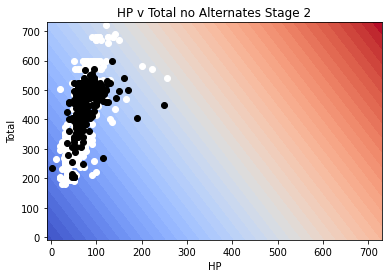

In [307]:
# Stage 2
Y = noMega['Stage']
Y = Y.replace([1,2,3], [0,1,0]).values.astype('float64') #if stage 2, Stage = 1, 0 otherwise
knn.train(X,Y)

#predict them!
prediction = []
for x in X:
    prediction.append(knn.predict(x))
predictions = [prediction[i].most_common(2)[0][0] for i in range(len(prediction))]

num_wrong = np.sum(np.not_equal(predictions, Y))
print(f'We got {num_wrong} wrong!\nSo {round(num_wrong/len(X) * 100, 3)}% of the data were wrongly predicted as Stage 2')

# plotting time
# make sure grid contains all of our data
r_min = np.min(X) - 10
r_max = np.max(X) + 10

xs, ys = np.meshgrid(np.arange(r_min, r_max, 0.1), np.arange(r_min, r_max, 0.1))
zs = [ [ f(xs[i,j], ys[i,j]) for j in range(len(ys)) ] for i in range(len(xs)) ]
print("Done")
plt.contourf(xs, ys, zs, levels = 50, cmap = 'coolwarm')
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], c = 'w')
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], c = 'k')
plt.xlabel("HP")
plt.ylabel("Total")
plt.title("HP v Total no Alternates Stage 2")


We got 64 wrong!
So 7.356% of the data were wrongly predicted as Stage 3
Done


Text(0.5, 1.0, 'HP v Total no Alternates Stage 3')

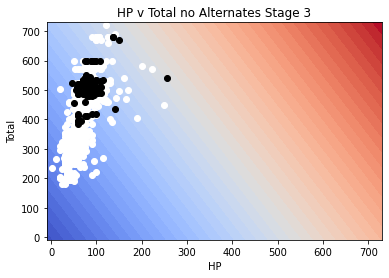

In [309]:
# Stage 3
Y = noMega['Stage']
Y = Y.replace([1,2,3], [0,0,1]).values.astype('float64') #if stage 3, Stage = 1, 0 otherwise
knn.train(X,Y)

#predict them!
prediction = []
for x in X:
    prediction.append(knn.predict(x))
predictions = [prediction[i].most_common(2)[0][0] for i in range(len(prediction))]

num_wrong = np.sum(np.not_equal(predictions, Y))
print(f'We got {num_wrong} wrong!\nSo {round(num_wrong/len(X) * 100, 3)}% of the data were wrongly predicted as Stage 3')

# plotting time
# make sure grid contains all of our data
r_min = np.min(X) - 10
r_max = np.max(X) + 10

xs, ys = np.meshgrid(np.arange(r_min, r_max, 0.1), np.arange(r_min, r_max, 0.1))
zs = [ [ f(xs[i,j], ys[i,j]) for j in range(len(ys)) ] for i in range(len(xs)) ]
print("Done")
plt.contourf(xs, ys, zs, levels = 50, cmap = 'coolwarm')
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], c = 'w')
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], c = 'k')
plt.xlabel("HP")
plt.ylabel("Total")
plt.title("HP v Total no Alternates Stage 3")


This is where the __No Legendaries__ set comes into play. :)

# No Legends Section

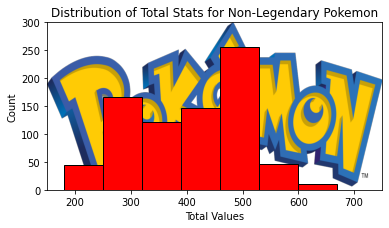

In [161]:
#distribution of total values (no legendaries)
noLeg = noMega[noMega['Legendary'] == 'N'] # for KNN alg

noLeg['Total'].hist(color = 'red', ec = 'black', grid = False, bins = 7)
plt.title("Distribution of Total Stats for Non-Legendary Pokemon")
plt.xlabel("Total Values")
plt.ylabel("Count")
plt.imshow(img, extent = [150, 750, 0, 300])

In [324]:
one = noLeg[noLeg['Stage'] == 1]
two = noLeg[noLeg['Stage'] == 2]
three = noLeg[noLeg['Stage'] == 3]

oneM = one['Total'].mean()
twoM = two['Total'].mean()
threeM = three['Total'].mean()

print(f'=========================\n\tNoLeg Total\n=========================\nStage 1 mean ~> {round(oneM,5)}')
print(f'Stage 2 mean ~> {round(twoM,5)}')
print(f'Stage 3 mean ~> {round(threeM,5)}\n=========================')

	NoLeg Total
Stage 1 mean ~> 336.344
Stage 2 mean ~> 445.89869
Stage 3 mean ~> 512.03636


As you can see, the mean for stage 1 dropped by over 10%. This should allow for a much more accurate prediction, and the scatterplot of the new data points is:

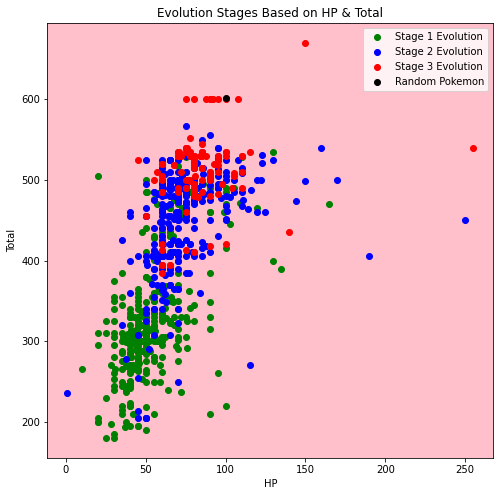

In [163]:
# SPLIT INTO OUR THREE STAGES 
stage_one = noLeg[noLeg['Stage'] == 1]
stage_two = noLeg[noLeg['Stage'] == 2]
stage_three = noLeg[noLeg['Stage'] == 3]

#make random pokemon
random_pokemon = [100, 601]

#PLOTTING
plt.scatter(x = stage_one['HP'], y = stage_one['Total'], color = 'g')
plt.scatter(x = stage_two['HP'], y = stage_two['Total'], color = 'b')
plt.scatter(x = stage_three['HP'], y = stage_three['Total'], color = 'r')
plt.scatter(x = random_pokemon[0], y = random_pokemon[1], color = 'black')
plt.title("Evolution Stages Based on HP & Total")
plt.legend(['Stage 1 Evolution', 'Stage 2 Evolution', 'Stage 3 Evolution', 'Random Pokemon'])
plt.xlabel("HP")
plt.ylabel("Total")
plt.gca().set_facecolor('pink')
plt.gcf().set_size_inches(8,8)

In [325]:
noLeg.describe()

,Stage,Attack,Defense,HP,Sp. Attack,Sp. Defense,Speed,Total
count,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000
mean,1.664981,73.279393,68.869785,66.194690,65.590392,66.664981,62.558786,403.158028
std,0.708198,28.185041,28.048818,24.654473,26.421972,24.942674,26.594875,98.568445
min,1.000000,5.000000,5.000000,1.000000,10.000000,20.000000,5.000000,180.000000
25%,1.000000,52.000000,50.000000,50.000000,45.000000,50.000000,42.500000,314.000000
50%,2.000000,70.000000,65.000000,65.000000,60.000000,65.000000,60.000000,413.000000
75%,2.000000,92.000000,85.000000,78.000000,85.000000,80.000000,80.000000,490.000000
max,3.000000,165.000000,230.000000,255.000000,145.000000,230.000000,160.000000,670.000000


In [380]:
#Predicting what stage a pokemon is based off of HP and Total
knn = l.KNN(3)

knn_set = noLeg[['HP', 'Total']].to_numpy()
labels = noLeg['Stage'].values 

knn.train(knn_set, labels)

#predict random pokemon from above
pred = knn.predict(random_pokemon)
print(f'The predicted stage of {random_pokemon} is ~> Stage {pred.most_common(1)[0][0]}')


The predicted stage of [100, 601] is ~> Stage 3


In [388]:
noLeg[noLeg['Stage'] == 3].describe()

,Stage,Attack,Defense,HP,Sp. Attack,Sp. Defense,Speed,Total
count,110.0,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
mean,3.0,93.800000,83.554545,83.827273,88.145455,85.472727,77.236364,512.036364
std,0.0,26.606132,23.624193,23.368551,24.755256,20.030119,23.750201,47.986414
min,3.0,10.000000,10.000000,45.000000,35.000000,50.000000,25.000000,385.000000
25%,3.0,76.250000,70.000000,75.000000,70.000000,73.500000,60.000000,490.000000
50%,3.0,95.000000,80.000000,80.000000,90.000000,85.000000,77.500000,518.500000
75%,3.0,113.750000,95.000000,90.000000,105.000000,95.000000,92.750000,533.000000
max,3.0,160.000000,180.000000,255.000000,145.000000,154.000000,142.000000,670.000000


In [391]:
#get averages for presentation
sumR1 = 0
sumR2 = 0
sumR3 = 0
for i in tqdm.tqdm(range(0,100)): 
   
    knn_set = noLeg[['HP', 'Total']].to_numpy()
    labels = noLeg['Stage'].values 
    
    #stage 1 randoms
    hp1 = np.random.randint(10,165, (100,1))
    tot1 = np.random.randint(180,535, (100,1))
    
    #stage 2
    hp2 = hp1 = np.random.randint(1,250, (100,1))
    tot2 = np.random.randint(260,568, (100,1))
    
    #stage 3
    hp3 = np.random.randint(45,256, (100,1))
    tot3 = np.random.randint(385,671, (100,1))
    
    #vstack ftw
    hp = np.vstack((hp1,hp2,hp3))
    tot = np.vstack((tot1, tot2, tot3))
    data2 = np.hstack((hp, tot))
    
    lab1 = np.random.randint(1,2,(100,1))
    lab2 = np.random.randint(2,3,(100,1))
    lab3 = np.random.randint(3,4,(100,1))
    label2 = np.vstack((lab1,lab2,lab3))
    
    k = 3
    knn = l.KNN(k)

    knn.train(knn_set,labels)

    prediction = []
    for x in data2:
        prediction.append(knn.predict(x))
    
    predictions = [prediction[i].most_common(2)[0][0] for i in range(len(prediction))]

    mcm = cm(label2,predictions)
    nmcm= cm(label2,predictions, normalize = 'true')
    #print('Confusion Matrix: \n', mcm)
    #print('\n Normalized Confusion Matrix: \n', nmcm)
    sumR1 += nmcm[0][0]
    sumR2 += nmcm[1][1]
    sumR3 += nmcm[2][2]
    
aveR1 = sumR1 / 100
aveR2 = sumR2 / 100
aveR3 = sumR3 / 100

print(f'Stage 1 Averaged {round(aveR1*100,3)}% Correct\nStage 2 Averaged {round(aveR2 * 100,3)}% Correct\nStage 3 Averaged {round(aveR3 * 100,3)}% Correct')
print('Confusion Matrix: \n', mcm)
print('\n Normalized Confusion Matrix: \n', nmcm)

100%|██████████| 100/100 [02:43<00:00,  1.64s/it]

Stage 1 Averaged 60.41% Correct
Stage 2 Averaged 50.11% Correct
Stage 3 Averaged 37.27% Correct
Confusion Matrix: 
 [[57 40  3]
 [52 38 10]
 [ 6 57 37]]

 Normalized Confusion Matrix: 
 [[0.57 0.4  0.03]
 [0.52 0.38 0.1 ]
 [0.06 0.57 0.37]]


As you can see, the algorithm is much better at predicting **Stage 2 and 3** pokemon due to the lack of legendaries. It also has a better idea of what **Stage 1** are _supposed_ to look like, notice the % of **Stage 1** pokemon that are predicted as **Stage 3** DRASTICALLY decreases. 

# Contour Plot Section (No Legendary)

We got 95 wrong!
So 12.01% of the data were wrongly predicted as Stage 1
Done


Text(0.5, 1.0, 'HP v Total no Alternates Stage 1')

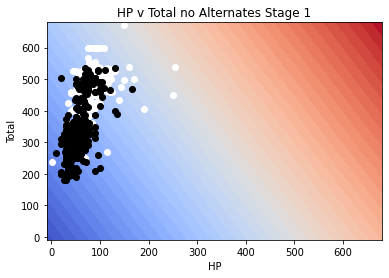

In [326]:
# Stage 1
XL = noLeg[['HP', 'Total']].values
YL = noLeg['Stage']
YL = YL.replace([1,2,3], [1,0,0]).values.astype('float64') #if stage 1, Stage = 1, 0 otherwise
knn.train(XL,YL)

#predict them!
predictionL = []
for x in XL:
    predictionL.append(knn.predict(x))
predictionsL = [predictionL[i].most_common(2)[0][0] for i in range(len(predictionL))]

num_wrong = np.sum(np.not_equal(predictionsL, YL))
print(f'We got {num_wrong} wrong!\nSo {round(num_wrong/len(XL) * 100, 3)}% of the data were wrongly predicted as Stage 1')

# plotting time
# make sure grid contains all of our data
r_min = np.min(XL) - 10 
r_max = np.max(XL) + 10

xsl, ysl = np.meshgrid(np.arange(r_min, r_max, 0.1), np.arange(r_min, r_max, 0.1))
zsl = [ [ f(xsl[i,j], ysl[i,j]) for j in range(len(ysl)) ] for i in range(len(xsl)) ]
print("Done")
plt.contourf(xsl, ysl, zsl, levels = 50, cmap = 'coolwarm')
plt.scatter(XL[YL == 0, 0], XL[YL == 0, 1], c = 'w')
plt.scatter(XL[YL == 1, 0], XL[YL == 1, 1], c = 'k')
plt.xlabel("HP")
plt.ylabel("Total")
plt.title("HP v Total no Alternates Stage 1")

We got 119 wrong!
So 15.044% of the data were wrongly predicted as Stage 2
Done


Text(0.5, 1.0, 'HP v Total no Alternates Stage 2')

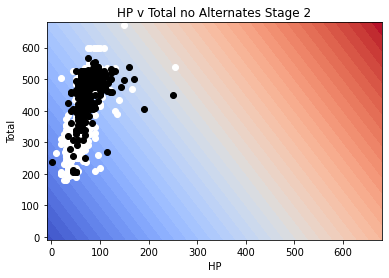

In [327]:
# Stage 2
XL = noLeg[['HP', 'Total']].values
YL = noLeg['Stage']
YL = YL.replace([1,2,3], [0,1,0]).values.astype('float64') #if stage 2, Stage = 1, 0 otherwise
knn.train(XL,YL)

#predict them!
predictionL = []
for x in XL:
    predictionL.append(knn.predict(x))
predictionsL = [predictionL[i].most_common(2)[0][0] for i in range(len(predictionL))]

num_wrong = np.sum(np.not_equal(predictionsL, YL))
print(f'We got {num_wrong} wrong!\nSo {round(num_wrong/len(XL) * 100, 3)}% of the data were wrongly predicted as Stage 2')

# plotting time
# make sure grid contains all of our data
r_min = np.min(XL) - 10 
r_max = np.max(XL) + 10

xsl, ysl = np.meshgrid(np.arange(r_min, r_max, 0.1), np.arange(r_min, r_max, 0.1))
zsl = [ [ f(xsl[i,j], ysl[i,j]) for j in range(len(ysl)) ] for i in range(len(xsl)) ]
print("Done")
plt.contourf(xsl, ysl, zsl, levels = 50, cmap = 'coolwarm')
plt.scatter(XL[YL == 0, 0], XL[YL == 0, 1], c = 'w')
plt.scatter(XL[YL == 1, 0], XL[YL == 1, 1], c = 'k')
plt.xlabel("HP")
plt.ylabel("Total")
plt.title("HP v Total no Alternates Stage 2")

We got 56 wrong!
So 7.08% of the data were wrongly predicted as Stage 3
Done


Text(0.5, 1.0, 'HP v Total no Alternates Stage 3')

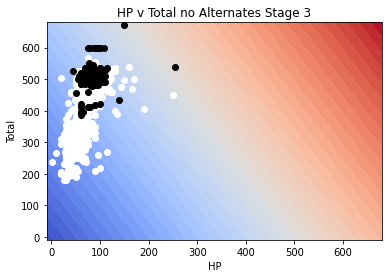

In [328]:
# Stage 3
XL = noLeg[['HP', 'Total']].values
YL = noLeg['Stage']
YL = YL.replace([1,2,3], [0,0,1]).values.astype('float64') #if stage 3, Stage = 1, 0 otherwise
knn.train(XL,YL)

#predict them!
predictionL = []
for x in XL:
    predictionL.append(knn.predict(x))
predictionsL = [predictionL[i].most_common(2)[0][0] for i in range(len(predictionL))]

num_wrong = np.sum(np.not_equal(predictionsL, YL))
print(f'We got {num_wrong} wrong!\nSo {round(num_wrong/len(XL) * 100, 3)}% of the data were wrongly predicted as Stage 3')

# plotting time
# make sure grid contains all of our data
r_min = np.min(XL) - 10 
r_max = np.max(XL) + 10

xsl, ysl = np.meshgrid(np.arange(r_min, r_max, 0.1), np.arange(r_min, r_max, 0.1))
zsl = [ [ f(xsl[i,j], ysl[i,j]) for j in range(len(ysl)) ] for i in range(len(xsl)) ]
print("Done")
plt.contourf(xsl, ysl, zsl, levels = 50, cmap = 'coolwarm')
plt.scatter(XL[YL == 0, 0], XL[YL == 0, 1], c = 'w')
plt.scatter(XL[YL == 1, 0], XL[YL == 1, 1], c = 'k')
plt.xlabel("HP")
plt.ylabel("Total")
plt.title("HP v Total no Alternates Stage 3")

# K-means Clustering

In [192]:
kMeans_set = pokemon[['Sp. Attack', 'Sp. Defense']]
kMeans_set

,Sp. Attack,Sp. Defense
0,65,65
1,80,80
2,100,100
3,122,120
4,60,50
...,...,...
1040,65,110
1041,145,80
1042,80,80
1043,85,130


In [278]:
class KMeansClassifier:
    """Given some data, determines k means to be used for classification"""
    def __init__(self):
        self.means = []
    
    def train(self, data, k):
        """Run the k-means algorithm, stores the final means in self.means"""
        
        # so we can be destructive
        copy_data = np.copy(data)
        
        # 1. choose k points at random from data
        
        # not necessary if data is all numeric
        # copy_data = copy.deepcopy(data)
        
        np.random.shuffle(copy_data)
        self.means = copy_data[:k] # grab the first k rows after a random shuff
        
        # 2. loop the following until self.means stops changing
        #    - for each self.means as m, gather all rows of copy_data
        #         for which m is the closest mean, call this group_m
        print(f'Before Training:\n{self.means}')        
        count = 0
        
        for i in tqdm.tqdm(range(len(copy_data))):
            plt.scatter(copy_data[i][0], copy_data[i][1], color = 'b')
            
        plt.scatter(means.means[0][0], means.means[0][1], color = 'r', s = 200)
        plt.scatter(means.means[1][0], means.means[1][1], color = '#C0FF02', s = 200)
        plt.scatter(means.means[2][0], means.means[2][1], color = '#FF00FF', s = 200)
        
        plt.xlabel('Sp. Attack')
        plt.ylabel('Sp. Defense')
        plt.gcf().set_size_inches(8,8)
        plt.gca().set_facecolor('pink')
        plt.show()
        while count < 5: # want to add a convergence check
           
            for i in range(len(self.means)):
                group = [0,0] # set of rows in copy_data for which self.means[i] is the closest mean
                           # aggregated group as a matrix, rows are rows of data
                for row in copy_data: #goes through all of data
                    num_times = 0
                    distances = []
                    for j in range(len(self.means)):
                        # calculate distance to self.means[i]
                        distances.append(la.norm(row - self.means[j]))
                    # if min distance is at index i, then np.vstack([ group, row ])
                    min0 = np.array(distances)
                    min0 = min0.argsort()
                    if min0[0] == i:
                        group = np.vstack([group, row])
                        
                        #plot here
                        if i == 1:
                            plt.scatter(row[0],row[1], color = 'w')
                        elif i == 0:
                            plt.scatter(row[0], row[1], color = 'k')
                        else:
                            plt.scatter(row[0], row[1], color = 'b')
                        
                
                # get rid of first row, which is 0,0 to make vstack work
                group = group[1:]
                """for i in np.unique(group):
                    points = group.values
                    # get convex hull
                    hull = ConvexHull(points)
                    # get x and y coordinates
                    # repeat last point to close the polygon
                    x_hull = np.append(points[hull.vertices,0],
                                       points[hull.vertices,0][0])
                    y_hull = np.append(points[hull.vertices,1],
                                       points[hull.vertices,1][0])
                    # plot shape
                    plt.fill(x_hull, y_hull, alpha=0.3, c=colors[i])"""
                    
                self.means[i] = np.mean(group, axis=0)
        #    - re-assign self.means[m] = mean(group_m)
            count += 1
            print(means.means)
            plt.scatter(means.means[0][0], means.means[0][1], color = 'r', s = 200)
            plt.scatter(means.means[1][0], means.means[1][1], color = '#C0FF02', s = 200)
            plt.scatter(means.means[2][0], means.means[2][1], color = '#FF00FF', s = 200)
            plt.xlabel('Sp. Attack')
            plt.ylabel('Sp. Defense')
            plt.gcf().set_size_inches(8,8)
            plt.gca().set_facecolor('pink')
            plt.show()
        print(f'After Training:\n{self.means}')
    
    
    def test(self, x):
        """Return the mean closest to x among self.means"""
        # find row of self.means that is the closest to x in euclidean distance
        # return it
        for i in range(len(self.means)):
            distance = []
            for j in range(len(self.means)):
                # calculate distance to self.means[i]
                distance.append(la.norm(x - self.means[j]))
            # if min distance is at index i, then np.vstack([ group, row ])
            min0 = np.array(distance)
            min0 = min0.argsort()
            if min0[0] == i:
                return min0[0]
        # to see if something screwed up
        print("Error :(")
        return -1

Before Training:
[[65 75]
 [65 55]
 [48 68]]


100%|██████████| 1045/1045 [00:03<00:00, 271.45it/s]


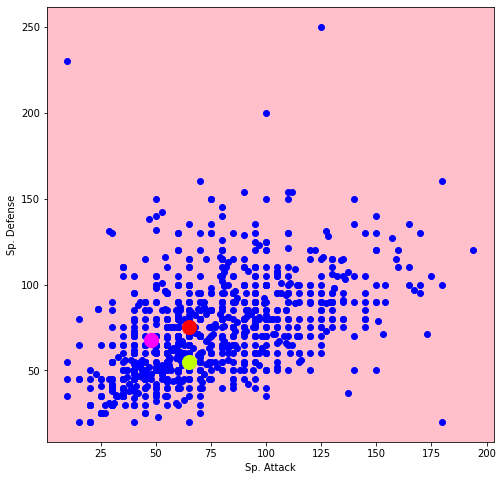

[[92 92]
 [65 52]
 [44 65]]


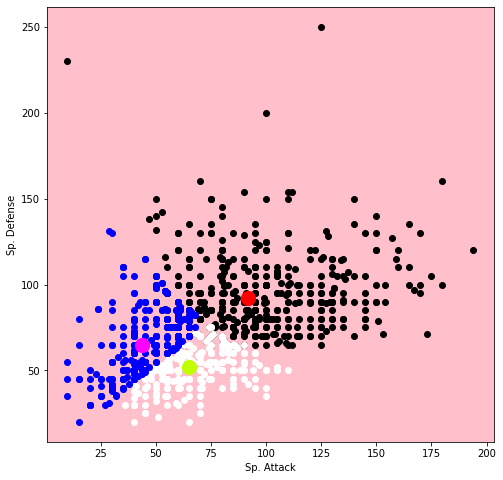

[[101  94]
 [ 67  54]
 [ 42  58]]


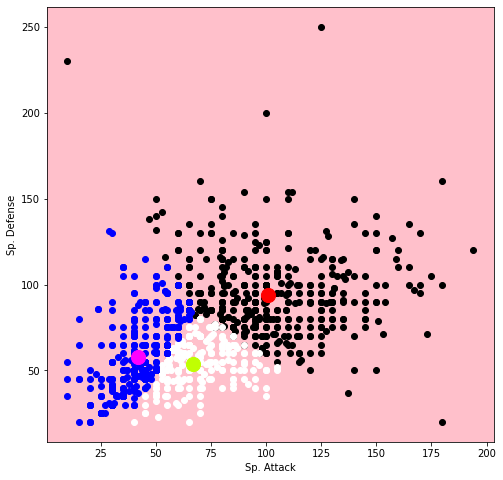

[[103  96]
 [ 70  60]
 [ 40  52]]


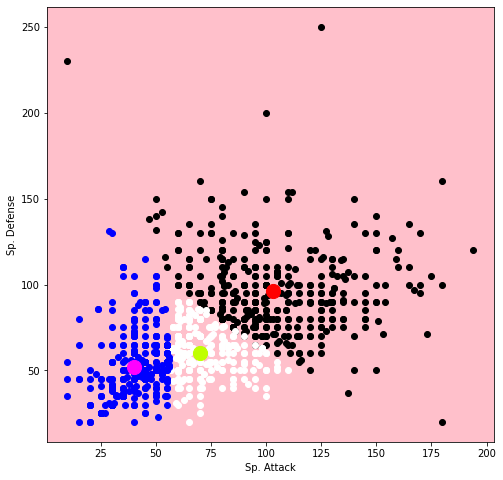

[[106  98]
 [ 70  67]
 [ 40  46]]


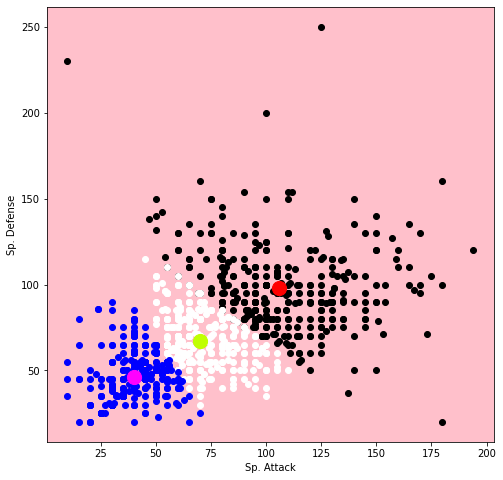

[[109  99]
 [ 69  71]
 [ 41  45]]


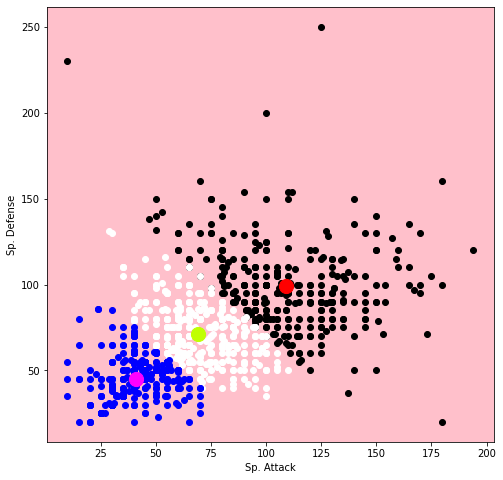

After Training:
[[109  99]
 [ 69  71]
 [ 41  45]]


In [279]:
means = KMeansClassifier()
means.train(kMeans_set, 3)

In [195]:
point = [75,75]
print(f'Mean that {point} is closest to ~> {means.test(point)}')

Mean that [75, 75] is closest to ~> 2


In [ ]:
# Fixing random state for reproducibility
np.random.seed(19680801)
# Fixing bin edges
HIST_BINS = np.linspace(-4, 4, 100)

# histogram our data with numpy
data = np.random.randn(1000)
n, _ = np.histogram(data, HIST_BINS)


In [ ]:
def prepare_animation(bar_container):

    def animate(frame_number):
        # simulate new data coming in
        data = np.random.randn(1000)
        n, _ = np.histogram(data, HIST_BINS)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        return bar_container.patches
    return animate


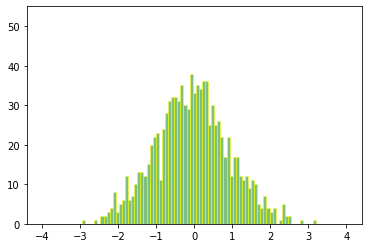

In [294]:
fig, ax = plt.subplots()
_, _, bar_container = ax.hist(data, HIST_BINS, lw=1,
                              ec="yellow", fc="green", alpha=0.5)
ax.set_ylim(top=55)  # set safe limit to ensure that all data is visible.

ani = fa(fig, prepare_animation(bar_container), 50,
                              repeat=False, blit=True)
plt.show()